In [4]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import h5py
import json
import scipy.sparse as sp
import time
import gget
import anndata as an
import scanpy as sc

# File paths

* Raw gene data -- `/nfs/turbo/umms-indikar/shared/projects/hybrid_reprogramming/anndata/raw_merged_gene_data.h5ad`
* Processed gene data -- `/nfs/turbo/umms-indikar/shared/projects/hybrid_reprogramming/anndata/processed_all_groups.h5ad`
* Gene annotation -- `/nfs/turbo/umms-indikar/shared/projects/hybrid_reprogramming/reference/refdata-gex-GRCh38-2024-A_genes.csv.gz`

Pipeline outputs
* Hybrid -- `/nfs/turbo/umms-indikar/shared/projects/hybrid_reprogramming/pipeline_outputs/hyb_epi2me_final/`
* Fibroblast controls -- `/nfs/turbo/umms-indikar/shared/projects/HSC/pipeline_outputs/cc_fibroblast_full/`

# Sequencing summary

In [5]:
paths = {
    'hybrid': '/nfs/turbo/umms-indikar/shared/projects/hybrid_reprogramming/pipeline_outputs/hyb_epi2me_final/hybrid/',
    'scfib': '/nfs/turbo/umms-indikar/shared/projects/HSC/pipeline_outputs/cc_fibroblast_full/scfib/',
}

data = []

for key, path in paths.items():
    print(key)
    json_path = os.path.join(path, f"{key}.config_stats.json")
    df = pd.read_json(json_path, orient='index')
    df.columns = [key]
    data.append(df)
    
df = pd.concat(data, ignore_index=False, axis=1)
print(f"{df.shape=}")
display(df)

hybrid
scfib
df.shape=(12, 2)


,hybrid,scfib
subreads,251082705,182431966
full_length,219302446,163541870
stranded,238458625,175445102
plus,41317873,24436220
minus,197140752,151008882
full_len,219302446,163541870
single_adapter1,9801688,6179922
single_adapter2,9354491,5723310
double_adapter2,6536837,2570029
other,2878283,2980413


# Raw data

In [6]:
%%time 
fpath = "/nfs/turbo/umms-indikar/shared/projects/hybrid_reprogramming/anndata/raw_merged_gene_data.h5ad"
rdata = sc.read_h5ad(fpath)
rdata

CPU times: user 86.4 ms, sys: 369 ms, total: 456 ms
Wall time: 921 ms


AnnData object with n_obs × n_vars = 19858 × 28702
    obs: 'MYOD-fb_counts', 'PRRX1-fb_counts', 'PRRX1_MYOD-fb_counts', 'assigned_condition', 'total_fb_counts', 'condition_counts_rate', 'G1-fb_counts', 'G2M-fb_counts', 'S-fb_counts', 'dataset', 'total_reads', 'total_genes'
    var: 'gene_id', 'gene_type', 'Chromosome', 'Start', 'End'

In [7]:
### --- Handle HYB cells with NaN feature barcode predictions ---
init_cells_hybrid = rdata[rdata.obs['dataset'] == 'Hybrid'].n_obs

# remove HYB cells with NaN feature barcode predictions
hybrid_to_remove = (rdata.obs['dataset'] == 'Hybrid') & (rdata.obs['assigned_condition'].isna())
cells_to_keep = ~(hybrid_to_remove)
rdata = rdata[cells_to_keep].copy()

final_cells_hybrid = rdata[rdata.obs['dataset'] == 'Hybrid'].n_obs
removed_hybrid_cells = init_cells_hybrid - final_cells_hybrid

print(f"Removed {removed_hybrid_cells} 'Hybrid' cells with unassigned feature barcodes")
print(f"Final shape: {rdata.shape}\n")


### --- Add new column for grouping HYB cells vs Controls ---
rdata.obs['pooled_condition'] = rdata.obs['assigned_condition'].replace({
    "G1": "Control",
    "S": "Control",
    "G2M": "Control",
    "PRRX1": "siPRRX1",
    "PRRX1_MYOD": "HYB",
    "MYOD": "mmMYOD1"
})

# fill remaining NaN feature barcode predictions (only control cells) with 'Control'
rdata.obs['pooled_condition'] = rdata.obs['pooled_condition'].fillna('Control')
print(f"Number of cells per condition:\n {rdata.obs['pooled_condition'].value_counts()}")

print(f"Final shape: {rdata.shape}")
rdata

Removed 1 'Hybrid' cells with unassigned feature barcodes
Final shape: (19857, 28702)

Number of cells per condition:
 pooled_condition
Control    8963
HYB        4174
siPRRX1    3955
mmMYOD1    2765
Name: count, dtype: int64
Final shape: (19857, 28702)


/tmp/ipykernel_977020/1142151457.py:17: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  rdata.obs['pooled_condition'] = rdata.obs['assigned_condition'].replace({


AnnData object with n_obs × n_vars = 19857 × 28702
    obs: 'MYOD-fb_counts', 'PRRX1-fb_counts', 'PRRX1_MYOD-fb_counts', 'assigned_condition', 'total_fb_counts', 'condition_counts_rate', 'G1-fb_counts', 'G2M-fb_counts', 'S-fb_counts', 'dataset', 'total_reads', 'total_genes', 'pooled_condition'
    var: 'gene_id', 'gene_type', 'Chromosome', 'Start', 'End'

## Cells

dataset
Hybrid     10894
Control     8963
Name: count, dtype: int64


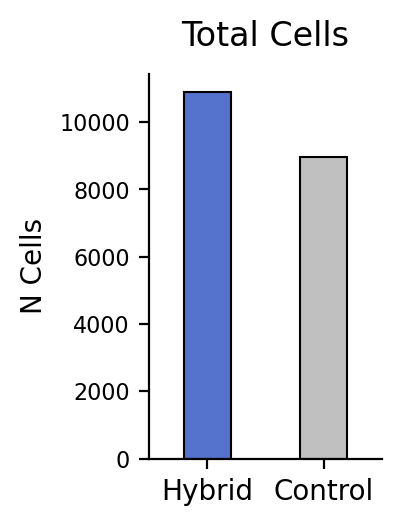

In [8]:
print(rdata.obs['dataset'].value_counts())

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 1.5, 2.5
fig, axs = plt.subplots()

dataset_colors = ["royalblue", "silver"]

sns.countplot(data=rdata.obs,
            x='dataset',
            hue='dataset',
            width=0.4,
            ec='k',
            linewidth=0.75,
            palette=dataset_colors,
           )

plt.ylabel("N Cells")
plt.xlabel("")

plt.title("Total Cells", pad=10)

plt.yticks(fontsize=8)

sns.despine()
plt.show()

## Genes

In [9]:
nonzero_matrix = rdata.X > 0

# Create a Series that maps each observation to its dataset
datasets = rdata.obs['dataset']

# Convert to DataFrame for grouping
nonzero_df = pd.DataFrame(nonzero_matrix.toarray() if hasattr(nonzero_matrix, "toarray") else nonzero_matrix,
                          index=rdata.obs_names,
                          columns=rdata.var_names)
nonzero_df['dataset'] = datasets.values

# Group by dataset and count number of genes (columns) with any non-zero value
genes_detected = nonzero_df.groupby('dataset', observed=True).apply(lambda x: (x.drop(columns='dataset').sum(axis=0) > 0).sum())

print(f"Number of non-zero genes:\n {genes_detected}\n")

Number of non-zero genes:
 dataset
Hybrid     27819
Control    23635
dtype: int64



/tmp/ipykernel_977020/193689094.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  genes_detected = nonzero_df.groupby('dataset', observed=True).apply(lambda x: (x.drop(columns='dataset').sum(axis=0) > 0).sum())


In [10]:
print(f"Median read depth: \n{rdata.obs.groupby('dataset', observed=True)['total_reads'].median()}")
display(rdata.obs.groupby('dataset', observed=True)['total_reads'].describe())

print(f"Median genes per cell: \n{rdata.obs.groupby('dataset', observed=True)['total_genes'].median()}")
display(rdata.obs.groupby('dataset', observed=True)['total_genes'].describe())

Median read depth: 
dataset
Hybrid     11731.0
Control    12844.0
Name: total_reads, dtype: float32


,count,mean,std,min,25%,50%,75%,max
dataset,,,,,,,,
Hybrid,10894.0,11572.786133,5878.607422,10.0,8176.75,11731.0,15014.25,46373.0
Control,8963.0,11848.504883,6289.082520,18.0,8830.50,12844.0,16045.00,35831.0


Median genes per cell: 
dataset
Hybrid     3786.0
Control    3405.0
Name: total_genes, dtype: float64


,count,mean,std,min,25%,50%,75%,max
dataset,,,,,,,,
Hybrid,10894.0,3588.252800,1308.280742,10.0,3139.0,3786.0,4359.0,7957.0
Control,8963.0,3036.596006,1428.829430,18.0,2655.5,3405.0,3998.0,6078.0


# Processed data

In [11]:
%%time 
fpath = "/nfs/turbo/umms-indikar/shared/projects/hybrid_reprogramming/anndata/processed_all_groups.h5ad"
adata = sc.read_h5ad(fpath)
adata

CPU times: user 268 ms, sys: 1.18 s, total: 1.45 s
Wall time: 4.31 s


AnnData object with n_obs × n_vars = 15950 × 25042
    obs: 'MYOD-fb_counts', 'PRRX1-fb_counts', 'PRRX1_MYOD-fb_counts', 'assigned_condition', 'total_fb_counts', 'condition_counts_rate', 'G1-fb_counts', 'G2M-fb_counts', 'S-fb_counts', 'dataset', 'total_reads', 'total_genes', 'pooled_condition', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'outlier', 'mt_outlier', 'S_score', 'G2M_score', 'phase', 'leiden', 'cluster_str', 'leiden_split'
    var: 'gene_id', 'gene_type', 'Chromosome', 'Start', 'End', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_counts', 'filter_pass', 'highly_variable', 'highly_variable_rank', 'm

## Cells

dataset
Hybrid     8990
Control    6960
Name: count, dtype: int64


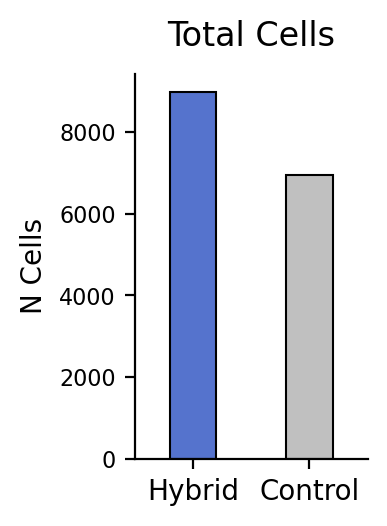

In [13]:
print(adata.obs['dataset'].value_counts())

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 1.5, 2.5
fig, axs = plt.subplots()

sns.countplot(data=adata.obs,
            x='dataset',
            hue='dataset',
            width=0.4,
            ec='k',
            linewidth=0.75,
            palette=dataset_colors,
           )

plt.ylabel("N Cells")
plt.xlabel("")

plt.title("Total Cells", pad=10)

plt.yticks(fontsize=8)

sns.despine()
plt.show()

In [20]:
print(f"Median read depth: \n{adata.obs.groupby('dataset', observed=True)['total_reads'].median()}")
display(adata.obs.groupby('dataset', observed=True)['total_reads'].describe())

print(f"Median genes per cell: \n{adata.obs.groupby('dataset', observed=True)['total_genes'].median()}")
display(adata.obs.groupby('dataset', observed=True)['total_genes'].describe())

Median read depth: 
dataset
Hybrid     12528.5
Control    14160.0
Name: total_reads, dtype: float32


,count,mean,std,min,25%,50%,75%,max
dataset,,,,,,,,
Hybrid,8990.0,13042.846680,4772.926758,3031.0,9929.25,12528.5,15530.75,46373.0
Control,6960.0,14571.326172,3911.703613,3503.0,11769.00,14160.0,17002.25,35831.0


Median genes per cell: 
dataset
Hybrid     3935.5
Control    3652.5
Name: total_genes, dtype: float64


,count,mean,std,min,25%,50%,75%,max
dataset,,,,,,,,
Hybrid,8990.0,3980.998443,835.220867,1759.0,3448.0,3935.5,4449.00,7957.0
Control,6960.0,3694.210201,683.347202,1494.0,3190.0,3652.5,4158.25,6078.0


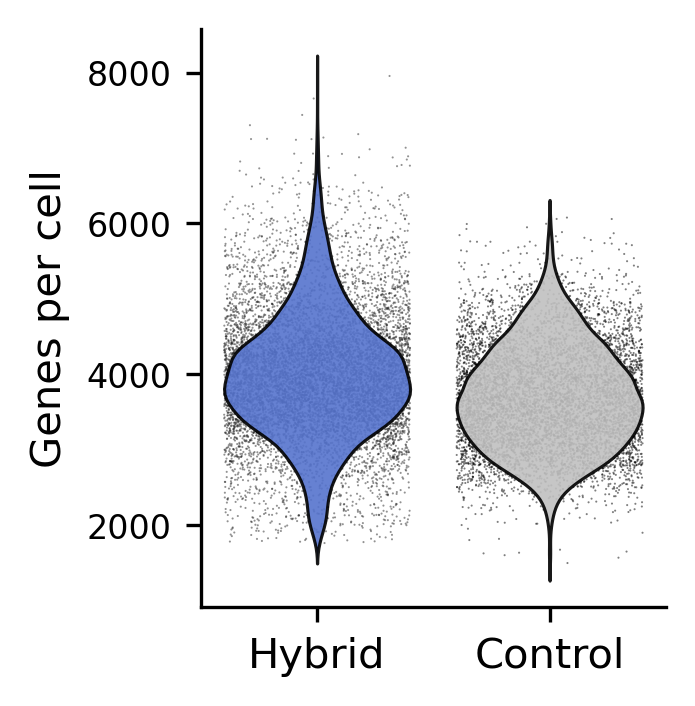

In [21]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 2, 2.5
fig, axs = plt.subplots()

dataset_colors = ["royalblue", "silver"]

ax = sns.violinplot(
    data=adata.obs,
    x='dataset',
    y='total_genes',
    hue='dataset',
    linewidth=0.75,
    linecolor='k',
    palette=dataset_colors,
    inner=None,
    alpha=0.9,
    zorder=1,
)

sns.stripplot(
    data=adata.obs,
    x='dataset',
    y='total_genes',
    hue='dataset',
    jitter=0.4, 
    palette='dark:black',
    edgecolor=None,
    size=0.5,       
    alpha=0.5,    
    ax=ax,        
    legend=False,
    zorder=0,
)

plt.ylabel("Genes per cell")
plt.xlabel("")
plt.yticks(fontsize=8)
sns.despine()
plt.show()

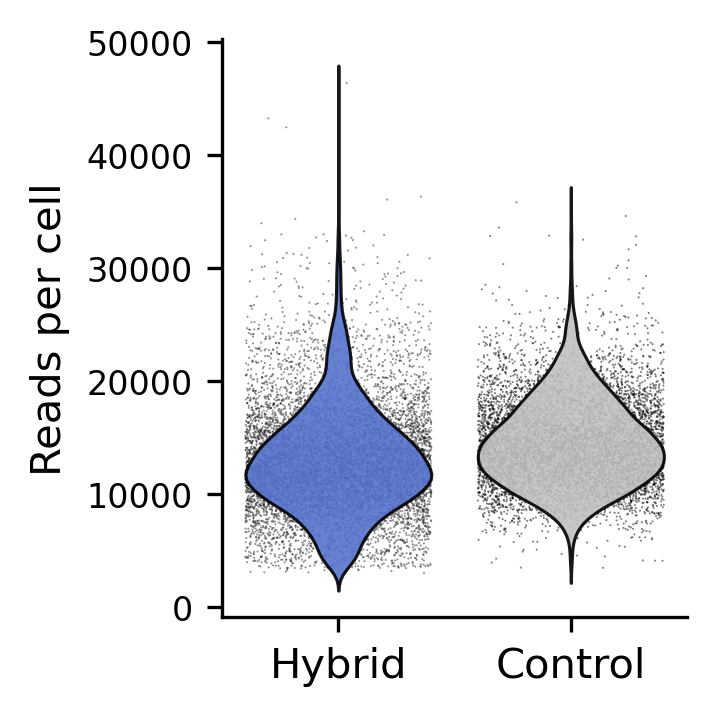

In [22]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 2, 2.5
fig, axs = plt.subplots()

dataset_colors = ["royalblue", "silver"]

ax = sns.violinplot(
    data=adata.obs,
    x='dataset',
    y='total_reads',
    hue='dataset',
    linewidth=0.75,
    linecolor='k',
    palette=dataset_colors,
    inner=None,
    alpha=0.9,
    zorder=1,
)

sns.stripplot(
    data=adata.obs,
    x='dataset',
    y='total_reads',
    hue='dataset',
    jitter=0.4, 
    palette='dark:black',
    edgecolor=None,
    size=0.5,       
    alpha=0.5,    
    ax=ax,        
    legend=False,
    zorder=0,
)

plt.ylabel("Reads per cell")
plt.xlabel("")
plt.yticks(fontsize=8)
sns.despine()
plt.show()

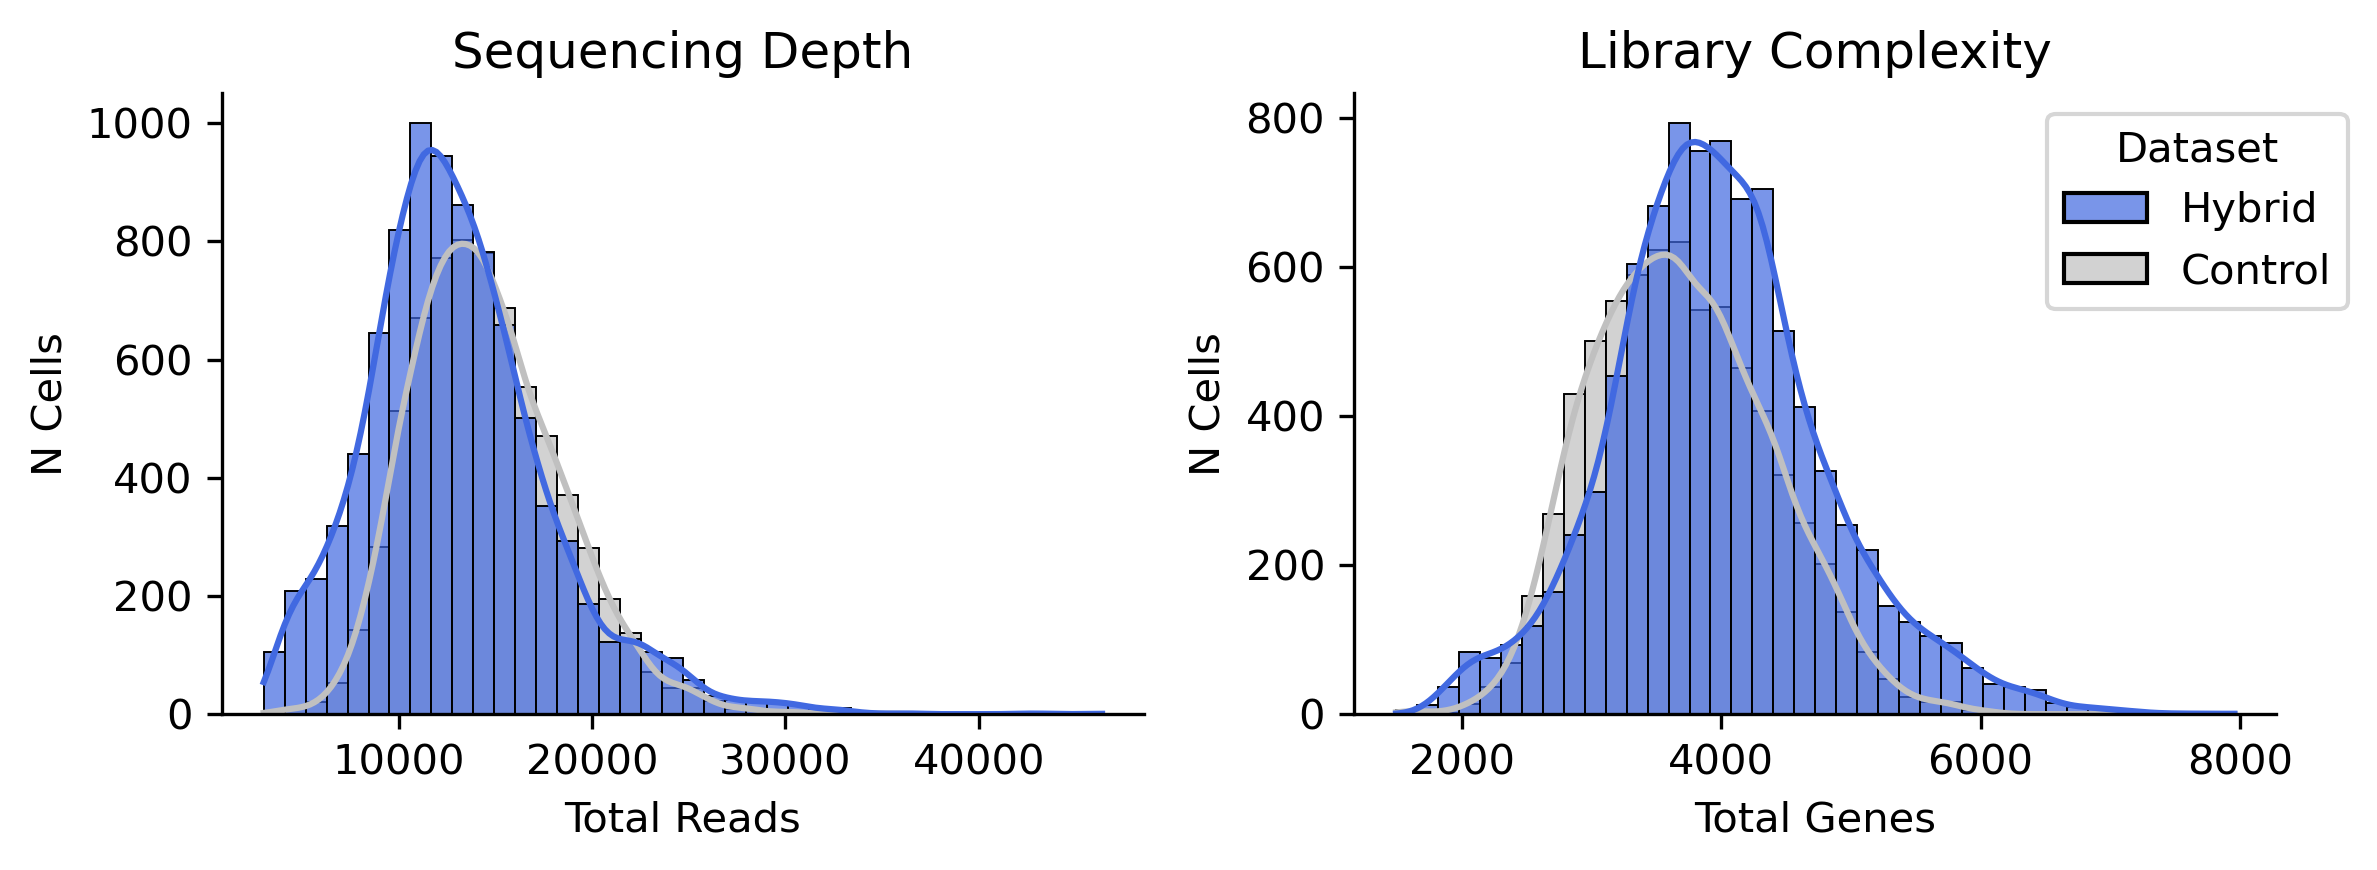

In [23]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 8, 3
fig, axs = plt.subplots(1, 2)

sns.histplot(data=adata.obs, x='total_reads', hue='dataset',
             palette=dataset_colors, bins=40, kde=True, ax=axs[0], legend=False, alpha=0.7)

axs[0].set_ylabel("N Cells")
axs[0].set_xlabel("Total Reads")
axs[0].set_title("Sequencing Depth")


sns.histplot(data=adata.obs, x='total_genes', hue='dataset',
             palette=dataset_colors, bins=40, kde=True, ax=axs[1], alpha=0.7)

axs[1].set_ylabel("N Cells")
axs[1].set_xlabel("Total Genes")
axs[1].set_title("Library Complexity")

sns.move_legend(plt.gca(), loc='upper right', title='Dataset', bbox_to_anchor=(1.1, 1))

sns.despine()
plt.tight_layout()
plt.show()

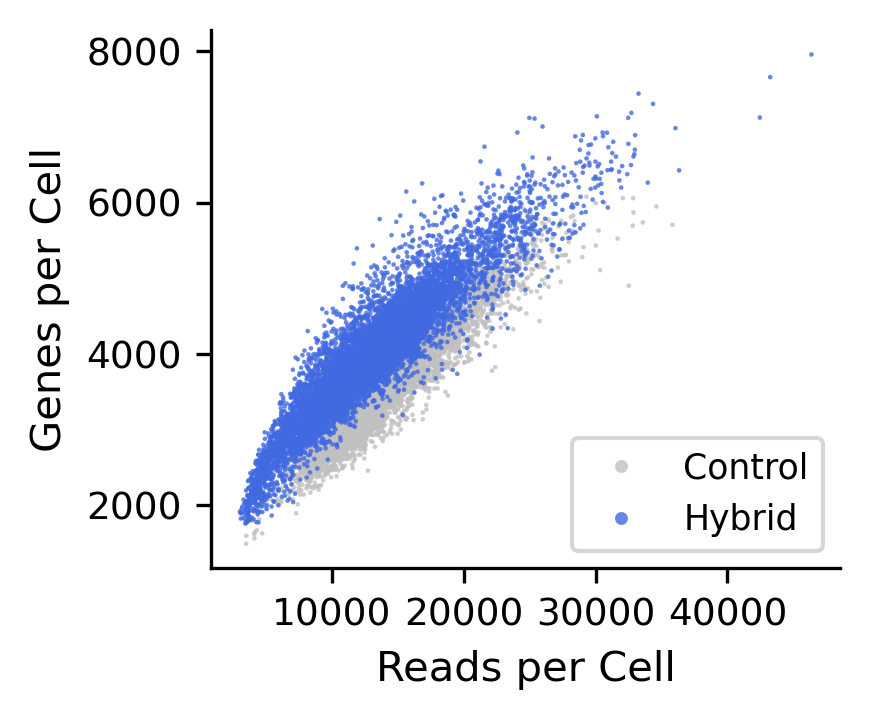

In [24]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 3, 2.5

df = adata.obs[['total_reads', 'total_genes', 'dataset']].copy()
df = df.sort_values(by='dataset', ascending=False)

dataset_colors = ["silver", "royalblue"]

sns.scatterplot(data=df,
                x='total_reads',
                y='total_genes',
                hue='dataset',
                hue_order=['Control', 'Hybrid'],
                palette=dataset_colors,
                s=1,
                edgecolor=None,
                alpha=0.8,
               )

sns.move_legend(plt.gca(), loc='lower right', fontsize='small', markerscale=3, title="")#, bbox_to_anchor=(1.1, 1))

plt.ylabel("Genes per Cell")
plt.xlabel("Reads per Cell")
plt.xticks(fontsize=9)
plt.yticks(fontsize=9)

sns.despine()
plt.tight_layout()
plt.show()

## Genes

In [14]:
gene_counts = {}

adata.X = adata.layers['raw_counts'].copy()

grouping_col = 'dataset'

for ds, idx in adata.obs.groupby(grouping_col, observed=True).indices.items():
    # subset of cells per dataset
    X_sub = adata[idx, :].X
    
    # count how many genes have at least one nonzero value
    detected = np.array((X_sub > 0).sum(axis=0)).ravel() > 0
    n_genes_detected = detected.sum()
    
    gene_counts[ds] = n_genes_detected

    
gene_counts_df = pd.DataFrame.from_dict(gene_counts, orient='index', columns=['Genes detected'])
gene_counts_df

,Genes detected
Hybrid,24725
Control,22423


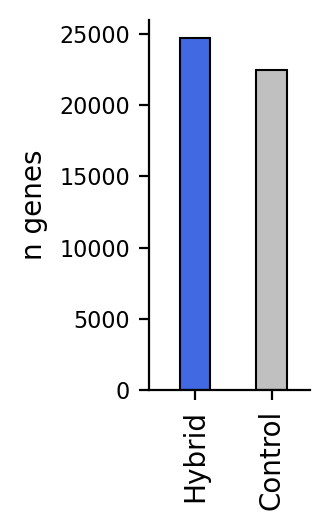

In [19]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 1.75, 2.75
fig, ax = plt.subplots()

ax.bar(
    x=gene_counts_df.index,
    height=gene_counts_df['Genes detected'],
    width=0.4,
    color=dataset_colors,
    edgecolor='k',
    linewidth=0.75,
)

plt.xticks(rotation=90)

ax.set_xticks([0, 1])
ax.set_xticklabels(['Hybrid', 'Control'])
ax.set_ylabel("n genes")
ax.set_xlim(-0.6, 1.5)
plt.yticks(fontsize=8)
# ax.set_ylim(0, 26000)

sns.despine()
plt.tight_layout()
plt.show()

count    2.504200e+04
mean     8.731604e+03
std      6.294420e+04
min      1.000000e+01
25%      9.300000e+01
50%      7.030000e+02
75%      4.128750e+03
max      4.626752e+06
Name: total_counts, dtype: float64

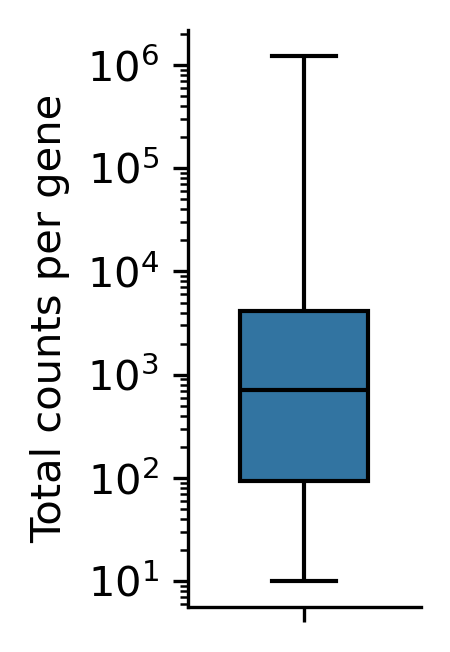

In [25]:
gene_counts = np.asarray(adata.X.sum(axis=0)).ravel()

### total counts per gene 
adata.var['total_counts'] = gene_counts

display(adata.var['total_counts'].describe())


plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 1, 2.5
fig, axs = plt.subplots()

sns.boxplot(
    adata.var['total_counts'],
    width=0.55,
    showfliers=False,
    linecolor='k',
    log_scale=True,
    #showcaps=False,
)

plt.ylabel("Total counts per gene")

sns.despine()
plt.show()